In [1]:
#standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras

#import generic model class
from tensorflow.keras import Model, Input

#imports for CNN model construction
from keras.regularizers import l2
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import  load_img, ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, AvgPool2D
from sklearn.model_selection import KFold

#import for study the performance of the model
from sklearn.metrics import roc_curve, auc, confusion_matrix

#imports for confusion matrix
import seaborn as sns
sns.set(style= "darkgrid", color_codes = True)
from keras.applications import VGG16

#imports for draw the model
import graphviz
import pydot
from keras.utils import plot_model
from IPython.display import Image

#imports random
import random as rn
from random import randrange

#imports for preprocessing the data
import glob
import os
import cv2

In [2]:
# Define a seed value for the random operations
seed_value = 42
rn.seed(seed_value)


In [3]:
# Define image size and other parameterst 

path = '/Users/giac/git/Tittarelli_Giacomo_RetiNeurali/chest_xray/'
dimension = 124
img_width, img_height = dimension, dimension
batchsize = 32
num_of_class = 2

train = keras. utils.image_dataset_from_directory(
    directory= path + 'train',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

test = keras. utils.image_dataset_from_directory(
    directory= path + 'test',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))


validation = keras. utils.image_dataset_from_directory(
    directory= path + 'val',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [4]:
# define paths
train_normal_dir = path + 'train/NORMAL/'
train_pneu_dir = path + 'train/PNEUMONIA/'

test_normal_dir = path + 'test/NORMAL/'
test_pneu_dir = path + 'test/PNEUMONIA/'

val_normal_dir = path + 'val/NORMAL/'
val_pneu_dir = path + 'val/PNEUMONIA/'

# find all files, our files has extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')

# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneu_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneu_cases:
    test_list.append([x, 1])
    
for x in val_normal_cases:
    val_list.append([x, 0])
    
for x in val_pneu_cases:
    val_list.append([x, 1])

    
# shuffle/randomize data as they were loaded in order: normal cases, then pneumonia cases
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])

In [5]:
# Preprocessing the data. It's important to resize the images in order to reduce the computational cost of the alghoritm
resize = 50

def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (resize, resize))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (resize,resize,1))
    
    return img

def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

In [6]:
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)

# Validation set
#val_size = .03

# Generate training and test set with stratification
# This means that we will find the same proportion of classes bot in the validation and in the training set
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, stratify=y_train)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (5216, 50, 50, 1), Labels shape: (5216,)
Test data shape: (624, 50, 50, 1), Labels shape: (624,)
Validation data shape: (16, 50, 50, 1), Labels shape: (16,)


In [7]:
# define generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# fit generator on our train features
datagen.fit(X_train)

y_train_cat = keras.utils.to_categorical(y_train, num_of_class)
y_val_cat = keras.utils.to_categorical(y_val, num_of_class)
y_test_cat = keras.utils.to_categorical(y_test, num_of_class)

In [8]:
# Model 
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu', input_shape=(resize, resize, 1)))
model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.05)))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

optimizer = Adam(learning_rate=1e-4, decay=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callback = EarlyStopping(monitor='loss', patience=6)


In [9]:
# model.summary()

In [10]:
"""
keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False,
)
"""

'\nkeras.utils.plot_model(\n    model,\n    to_file="model.png",\n    show_shapes=True,\n    show_dtype=False,\n    show_layer_names=True,\n    rankdir="TB",\n    expand_nested=False,\n    dpi=96,\n    layer_range=None,\n    show_layer_activations=True,\n    show_trainable=False,\n)\n'

In [11]:
# Define some hyperparameter
epochs = 30
batch_size = 12

#num_normal_training= 1.342 
#num_pneunomia_training= 3.876 
#w0 = (num_normal_training + num_pneunomia_training)/num_normal_training
#w1 = (num_normal_training + num_pneunomia_training)/num_pneunomia_training
class_weights =  {0: 3.5, 1: 1.1} 

In [12]:
# Train the model

history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=batch_size),
    validation_data=(X_val, y_val_cat),
    epochs=epochs,
    verbose=1,
    callbacks=[callback],
    class_weight=class_weights
)

Epoch 1/30
435/435 [==============================] - 10s 22ms/step - loss: 5.4499 - accuracy: 0.3857 - val_loss: 3.2801 - val_accuracy: 0.6875
Epoch 2/30
435/435 [==============================] - 10s 22ms/step - loss: 2.5729 - accuracy: 0.8175 - val_loss: 1.6999 - val_accuracy: 0.8125
Epoch 3/30
435/435 [==============================] - 10s 22ms/step - loss: 1.4351 - accuracy: 0.8681 - val_loss: 1.0186 - val_accuracy: 0.8750
Epoch 4/30
435/435 [==============================] - 10s 22ms/step - loss: 0.9507 - accuracy: 0.8854 - val_loss: 0.6570 - val_accuracy: 0.8125
Epoch 5/30
435/435 [==============================] - 10s 22ms/step - loss: 0.7168 - accuracy: 0.8976 - val_loss: 0.5164 - val_accuracy: 0.8750
Epoch 6/30
435/435 [==============================] - 10s 22ms/step - loss: 0.5894 - accuracy: 0.9005 - val_loss: 0.3844 - val_accuracy: 0.9375
Epoch 7/30
435/435 [==============================] - 10s 23ms/step - loss: 0.5195 - accuracy: 0.9103 - val_loss: 0.3369 - val_accuracy:

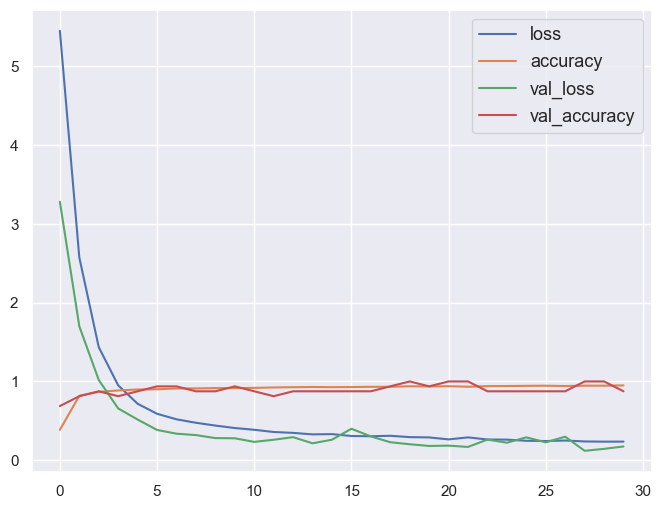

In [13]:
#plot learning curves

fig, ax = plt.subplots(figsize=(8,6))

for metric in history.history:
    
    #subtract half epoch from training data
    if len(metric.split('_')) < 2:
        ax.plot(np.array(history.epoch), history.history[metric], label=metric)
    else:
        ax.plot(history.epoch, history.history[metric], label=metric)
    
ax.grid(True)    

ax.legend(fontsize=13);

In [14]:
# prediction on test set
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# compute the confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

20/20 [==============================] - 0s 8ms/step


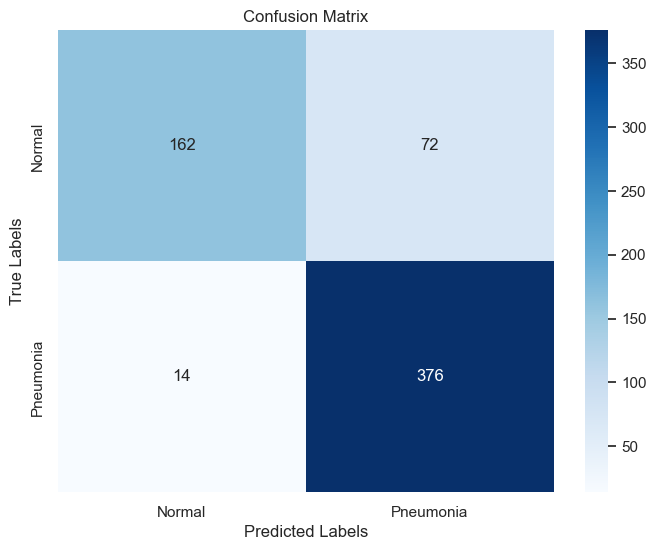

None


In [15]:
# show the confusion matrix

class_labels = ["Normal", "Pneumonia"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(plt.show())

In [16]:
# Estrai i valori dalla matrice di confusione
tp = conf_matrix[0][0]
fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
tn = conf_matrix[1][1]

# Calcola sensibilità (recall)
sensibility = tp / (tp + fn)

# Calcola specificità
specificity = tn / (tn + fp)

print("Sensibilità: {:.2f}".format(sensibility))
print("Specificità: {:.2f}".format(specificity))

Sensibilità: 0.92
Specificità: 0.84


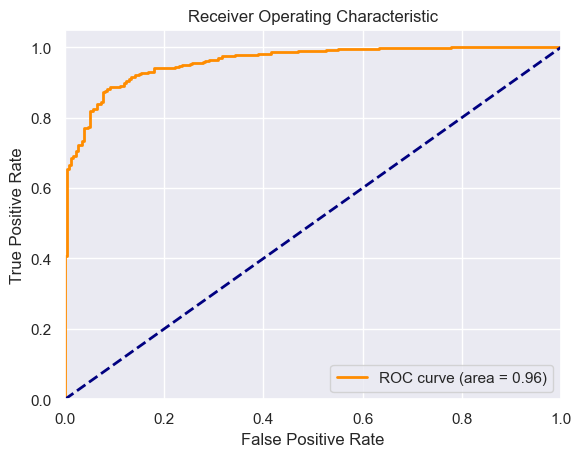

In [17]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions[:, 1])
roc_auc = auc(fpr, tpr)

# Show the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()